# DEMO

## 載入金屬模型

In [1]:
import torch, platform
print("PyTorch  版本 :", torch.__version__)
print("CUDA 可用？  :", torch.cuda.is_available())   # 應輸出 False
print("CPU only ？ :", torch.version.cuda is None)  # 應輸出 True
print("Python 版本 :", platform.python_version())
import os
os.chdir("/work/u5066474/NTHU/LiveTransForM-main")
device = torch.device("cpu") 
os.getcwd()
os.chdir("/work/u5066474/NTHU/LiveTransForM-main")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

import sys, pickle
import pandas as pd
sys.path.append("MetalGCN/model")
sys.path.append("MetalGCN/src")

from metal_pka_transfer import CustomMetalPKA_GNN, load_config_by_version, create_weight_tables
version = "metal_ver16"
cfg = load_config_by_version("MetalGCN/data/parameters.csv", version)
def load_model(version: str):
    
    os.chdir("MetalGCN/model")
    with open(cfg["dataloader_path"], "rb") as f:
        dl_train, dl_val, dl_test, mu, sigma, n_metals = pickle.load(f)
        print(f"已加載預處理的資料: {cfg['dataloader_path']}")
    bin_edges, bin_w = create_weight_tables(cfg["version"])

    model = CustomMetalPKA_GNN(n_metals, cfg["metal_emb_dim"],
                               cfg["num_features"],  # node_dim
                               9, # 先測試沒有spd的版本
                               cfg["hidden_size"],
                               cfg["output_size"],
                               cfg["dropout"],
                               cfg["depth"],
                               cfg["heads"],
                                bin_edges=bin_edges,
                                bin_weights=bin_w,
                                huber_beta=cfg["huber_beta"],
                                reg_weight=cfg["reg_weight"],
                               ).to(device)
    
    state_dict = torch.load(
        os.path.join(cfg["output_dir"], "best_model.pt"),
        map_location="cpu",      # 關鍵：把 cuda tensor 映射到 CPU
        weights_only=True        # 若 PyTorch >=2.2 支援；否則拿掉
    )
    model.load_state_dict(state_dict, strict=True)   # 只有 strict 參數

    os.chdir("../")
    return model


PyTorch  版本 : 2.7.1+cpu
CUDA 可用？  : False
CPU only ？ : True
Python 版本 : 3.9.23


In [2]:
metal_model = load_model(version)
metal_model.eval()

已加載預處理的資料: ../data/dataloader.pt
[NPZ] 權重表已存於 ../data/metal_ver16_pka_weight_table.npz


CustomMetalPKA_GNN(
  (node_proj): Linear(in_features=74, out_features=384, bias=True)
  (transformer): TransformerConv(384, 48, heads=8)
  (gate): Sequential(
    (0): Linear(in_features=384, out_features=384, bias=True)
    (1): Tanh()
  )
  (atom_classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
  (atom_regressor): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Squeeze1D()
  )
  (criterion_reg): MSELoss()
  (coordination_edge_generator): Linear(in_features=66, out_features=9, bias=True)
  (metal_emb): Embedding(10, 8)
  (dim_reduction): Identity()
)

## 載入pKa模型

In [3]:
import os 
os.chdir("/work/u5066474/NTHU/LiveTransForM-main/OMGNN/src")
os.getcwd()
from self_pka_sample import load_model

In [4]:
pKa_model = load_model(version="pka_ver26")
pKa_model.eval()

[MODEL] 載入 pka_ver26 → ../results/pka_ver26/pka_ver26_best.pkl


pka_GNN_ver3(
  (x_proj): Linear(in_features=153, out_features=384, bias=False)
  (pe_proj): Linear(in_features=8, out_features=384, bias=False)
  (gcn3): TransformerConv(384, 48, heads=8)
  (gate): Sequential(
    (0): Linear(in_features=384, out_features=384, bias=True)
    (1): Tanh()
  )
  (atom_classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
  (atom_regressor): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Squeeze1D()
  )
  (criterion_reg): SmoothL1Loss()
)

---

# 生成兩個模型

### 選定Ligand

In [5]:
ligand = "CC(O)(P(=O)(O)O)P(=O)(O)O"
metal = "Cu2+"

## 金屬

In [6]:
print("μ =", metal_model.pka_mu.item(), "σ =", metal_model.pka_sigma.item())

μ = 5.987196922302246 σ = 5.611271858215332


In [14]:
metal_model.eval()
metal_res = metal_model.sample(ligand, metal, device=torch.device("cpu"))
print(metal_res)

{'smiles': 'CC(O)(P(=O)(O)O)P(=O)(O)O', 'metal_ion': 'Cu2+', 'pred_pka': array([2.181885  , 3.23152804, 3.67843962, 5.31842709, 5.78984356]), 'atom_indices': [2, 5, 6, 9, 10]}


In [ ]:
metal_res['pred_pka']

## pKa

In [6]:
pKa_model.pka_mean, pKa_model.pka_std

(tensor([6.1166]), tensor([2.8283]))

In [16]:
pKa_model.eval()
pKa_res = pKa_model.sample(ligand, device=torch.device("cpu"))
print(pKa_res)

{'smiles': 'OC(=O)CC[Te]CCC(O)=O', 'pred_pka': array([3.73853827, 4.94635105]), 'atom_indices': [9, 0]}


In [17]:
pKa_res['pred_pka']

array([3.73853827, 4.94635105])

---

## DEMO

In [19]:
%matplotlib inline

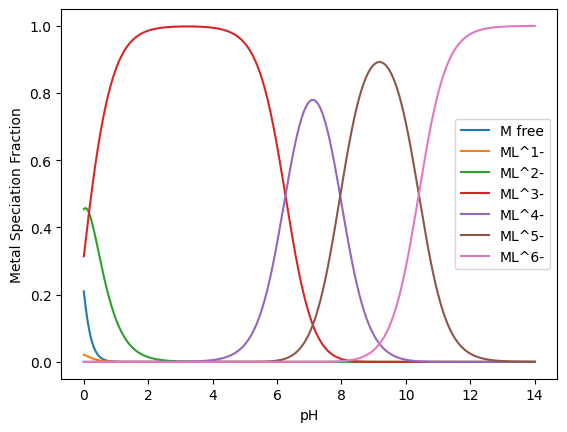

In [18]:
# --- 1. 已知：EDTA 的 pKa 與對應 β_j（以 1:1 配位為例） ---
pKa  = [1.99, 2.67, 6.16, 10.26, 11.96, 13.4]   # EDTA 的質子解離 pK
beta = [1, 1e4, 1e8, 1e14, 1e18, 1e22, 1e25]   # 假設的整步 β_j

# --- 2. 計算 α_j(pH) ---
n   = len(pKa)
pH  = np.linspace(0,14,701)
cum_pKa = np.concatenate([[0], np.cumsum(pKa)])
exps = np.outer(pH, np.arange(0,n+1)) - cum_pKa  # shape=(701,n+1)
denom = np.sum(10**exps, axis=1, keepdims=True)
alpha = (10**exps) / denom                       # shape=(701,n+1)

# --- 3. 條件形成常數 K'_j(pH) = β_j * α_j(pH) ---
Kp = alpha * beta  # shape=(701,n+1)

# --- 4. 設定總配體濃度 [L]_tot（例如 1 mM） ---
Ltot = 1e-3

# --- 5. 計算自由金屬與各 M·L_j 分率 ---
sum_KpL = np.sum(Kp[:,1:] * Ltot, axis=1)  # j=1..n
alpha_M_free = 1/(1 + sum_KpL)
alpha_ML = (Kp[:,1:] * Ltot) * alpha_M_free[:, None]

# --- 6. 繪圖 ---
labels = ['M free'] + [f'ML^{j}-' for j in range(1,n+1)]
plt.plot(pH, alpha_M_free, label=labels[0])
for j in range(n):
    plt.plot(pH, alpha_ML[:,j], label=labels[j+1])
plt.xlabel('pH')
plt.ylabel('Metal Speciation Fraction')
plt.legend(loc='best')
plt.show()

# Final graph

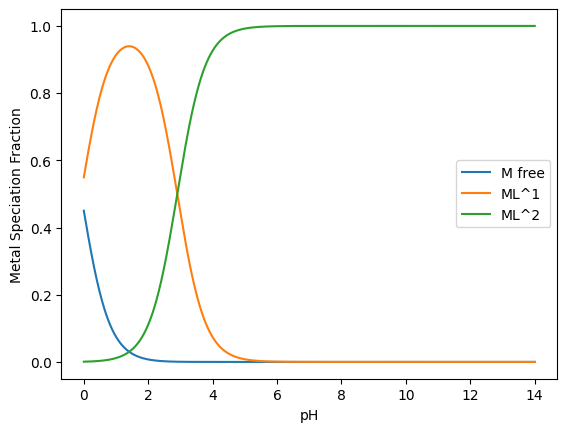

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# ── 0. 你的模型輸出的「log β」────────────
log_beta_pred = metal_res['pred_pka']   # logβ₁, logβ₂
# log_beta_pred = [8.08496952, 21.01017761]   # logβ₁, logβ₂

# ── 1. pKa（這裡示範兩個步驟）────────────
# pKa = [8.66739559, 10.18522072]             # ← 你自己決定
pKa = pKa_res['pred_pka']             # ← 你自己決定

# ── 2. 把 log β 轉成線性 β ───────────────
beta = [1.0]                                # β₀ = 1
beta += list(10 ** np.array(log_beta_pred)) # β₁, β₂
beta = np.array(beta)                       # 轉成 ndarray

# ── 3. 後面程式保持不變 ──────────────────
n   = len(pKa)              # pKa 階數 (這裡 n = 2)
pH  = np.linspace(0, 14, 701)

cum_pKa = np.concatenate([[0], np.cumsum(pKa)])
exps = np.outer(pH, np.arange(0, n + 1)) - cum_pKa
alpha = (10 ** exps) / (10 ** exps).sum(axis=1, keepdims=True)

Kp = alpha * beta           # 每個 pH 的條件形成常數 β′
Ltot = 1e-3                 # 配體總濃度 (1 mM)


# 新增濃度控制
Mtot = 1e-4  # 例：100 μM
Ltot = 1e-3  # 配體總濃度（1 mM）

sum_KpL   = (Kp[:, 1:] * Ltot).sum(axis=1)
alpha_M0  = 1 / (1 + sum_KpL / Mtot)     # 修正金屬濃度比例
alpha_MLj = (Kp[:, 1:] * Ltot / Mtot) * alpha_M0[:, None]

# sum_KpL   = (Kp[:, 1:] * Ltot).sum(axis=1)
# alpha_M0  = 1 / (1 + sum_KpL)          # 自由金屬分率
# alpha_MLj = (Kp[:, 1:] * Ltot) * alpha_M0[:, None]

# ── 4. 畫圖 ───────────────────────────────
labels = ['M free'] + [f'ML^{j}' for j in range(1, n + 1)]
plt.plot(pH, alpha_M0, label=labels[0])
for j in range(n):
    plt.plot(pH, alpha_MLj[:, j], label=labels[j + 1])

plt.xlabel('pH')
plt.ylabel('Metal Speciation Fraction')
plt.legend()
plt.show()
